# LANL Earthquake Prediction

## Get Data and EDA:

First of all let's define some variables and basic functions

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from math import ceil

DATA_DIR = "data/"
TRAIN_DATA_DIR = os.path.join(DATA_DIR, "train/")
TEST_DATA_DIR = os.path.join(DATA_DIR, "test/")
SAMPLE_SIZE = 150000


train_files = os.listdir(TRAIN_DATA_DIR)
n_train_files = len(train_files)
test_files = os.listdir(TEST_DATA_DIR)
n_test_files = len(test_files)


# function that prints the progress of function
# based on the number of iterations and the 
# current iteration
def print_progress(it, n_elements):
    bit = ceil(n_elements / 100)
    if it % bit == 0:
            print(int(it / bit), end='.')
            
            
        



The training data for this project is huge it is a csv file containing 629145480 rows with two columns, corresponding to the acoustic data and the corresponding time to failure. Based on the test dataset, each sample is of the size of 150000 rows. To study the dataset we don't use all the dataset because it would be very slow and innecessary, thus let's try to use only 5 samples. For the training I divided the dataset into 4194 csv files, this helps with the memory usage

In [2]:
n_samples = 5
data = pd.read_csv(os.path.join(DATA_DIR, "train.csv"), nrows=SAMPLE_SIZE * n_samples)

In [3]:
data.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


Let's see a graphic representation of the acoutic_data, using a plot a histogram and a boxplot

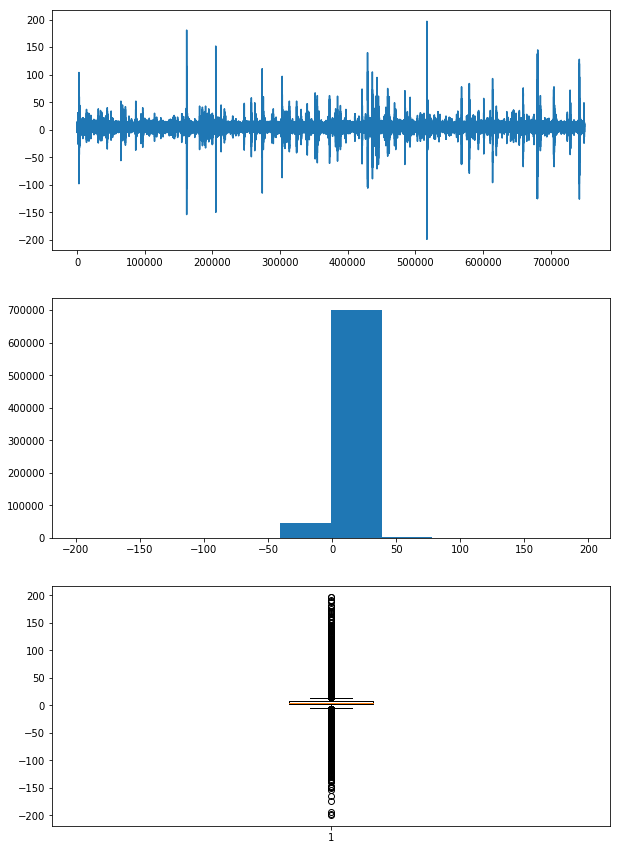

In [11]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(10, 15))
plt.subplot(311)
plt.plot(data["acoustic_data"])
plt.subplot(312)
plt.hist(data["acoustic_data"])
plt.subplot(313)
plt.boxplot(data["acoustic_data"])
plt.show()


The boxplot seems to have a very flattened box, it seems the values have a very close proximity although there are a lot of outliers. Let's look closer to the data by printing the percentiles and other estimates

In [5]:
from scipy import stats
from statsmodels import robust

def print_data(data):
    for i in range(0, 105, 5):
        print(str(i) + "%: ", np.percentile(data, i))
    print("iqr:", np.subtract(*np.percentile(data, [75, 25])))
    print("sd:", data.std())
    print("mean:", data.mean())
    print("var:", data.var())
    print("mad:", robust.mad(np.array(data)))
    print("trimmed_mean:", stats.trim_mean(np.array(data), 0.1))
    print("skew:", stats.skew(np.array(data)))
    print("kurtosis:", stats.kurtosis(np.array(data)))

We can see there is a lot of variability between percentiles. We can see that even if we trim 10% of the data the mean is almost exactly the same. That is because most of the data is very close together with the execption of some extremes values that cancel each other when computing the normal mean. We can see from kurtosis that the data has a propensity to have extreme values. We calculated that the data does not have a lot of skewnsess, we can see that to in the histogram

In [6]:
print_data(data["acoustic_data"])

0%:  -199.0
5%:  -2.0
10%:  0.0
15%:  1.0
20%:  2.0
25%:  2.0
30%:  3.0
35%:  3.0
40%:  4.0
45%:  4.0
50%:  5.0
55%:  5.0
60%:  6.0
65%:  6.0
70%:  7.0
75%:  7.0
80%:  8.0
85%:  9.0
90%:  10.0
95%:  12.0
100%:  197.0
iqr: 5.0
sd: 6.621580113104762
mean: 4.865446666666666
var: 43.84532319426447
mad: 2.965204437011204
trimmed_mean: 4.855716666666667
skew: 0.31673758988887757
kurtosis: 73.5997143942537


From the graph below we can see that there isn't too much correlation between the the acoustic data and the time to failure. By implementing new features for each sample based on data estimators we can develope more correlated features, thus making a better predictor

In [7]:
data.corr()

,acoustic_data,time_to_failure
acoustic_data,1.000000,-0.005397
time_to_failure,-0.005397,1.000000


As we can see from the following qqnorm, the samples do not have a normal distribution

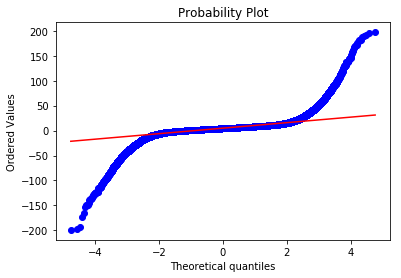

In [8]:
import pylab 
import scipy.stats as stats
  
stats.probplot(np.array(data["acoustic_data"]), dist="norm", plot=pylab)
pylab.show()

## Create dataset with all the features

Now that we have developed new features let's create a new dataset with each estimate

In [2]:
# define feature names
feature_columns = ["iqr", "mean", "sd", "var", "mad", "skew", "kurt"]
for i in range(0, 105, 5):
    feature_columns.append(str(i) + "%qt")
    
for windows in [10, 100, 1000]:
    feature_columns.append('ave_roll_std_' + str(windows))
    feature_columns.append('std_roll_std_' + str(windows))
    feature_columns.append('max_roll_std_' + str(windows))
    feature_columns.append('min_roll_std_' + str(windows))
    feature_columns.append('q01_roll_std_' + str(windows))
    feature_columns.append('q05_roll_std_' + str(windows))
    feature_columns.append('q95_roll_std_' + str(windows))
    feature_columns.append('q99_roll_std_' + str(windows))
    feature_columns.append('av_change_abs_roll_std_' + str(windows))
    feature_columns.append('abs_max_roll_std_' + str(windows))
    feature_columns.append('ave_roll_mean_' + str(windows))
    feature_columns.append('std_roll_mean_' + str(windows))
    feature_columns.append('max_roll_mean_' + str(windows))
    feature_columns.append('min_roll_mean_' + str(windows))
    feature_columns.append('q01_roll_mean_' + str(windows))
    feature_columns.append('q05_roll_mean_' + str(windows))
    feature_columns.append('q95_roll_mean_' + str(windows))
    feature_columns.append('q99_roll_mean_' + str(windows))
    feature_columns.append('av_change_abs_roll_mean_' + str(windows))
    feature_columns.append('abs_max_roll_mean_' + str(windows))

    
n_features = len(feature_columns)


X_data = pd.DataFrame(index=range(n_train_files), dtype=np.float32,
                       columns=feature_columns)

y_data = pd.DataFrame(index=range(n_train_files), dtype=np.float32,
                       columns=['time_to_failure'])

For now the dataset is empty, let't fill it in

In [10]:
X_data.head()

,iqr,mean,sd,var,mad,skew,kurt,0%qt,5%qt,10%qt,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
y_data.head()

,time_to_failure
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [5]:

def make_dataset():
    for i, file in enumerate(train_files):
        print_progress(i, n_train_files)
        seg = pd.read_csv(os.path.join(TRAIN_DATA_DIR, file))
        # for each instance we set the target to the mean
        y_data.iloc[i]['time_to_failure'] = seg['time_to_failure'].mean()
        X_data.iloc[i][feature_columns[1]] = seg['acoustic_data'].mean()
        X_data.iloc[i][feature_columns[2]] = seg['acoustic_data'].std()
        X_data.iloc[i][feature_columns[3]] = seg['acoustic_data'].var()
        X_data.iloc[i][feature_columns[4]] = robust.mad(np.array(seg['acoustic_data']))
        X_data.iloc[i][feature_columns[5]] = stats.skew(np.array(seg['acoustic_data']))
        X_data.iloc[i][feature_columns[6]] = stats.kurtosis(np.array(seg['acoustic_data']))
        
        for windows in [10, 100, 1000]:
            x_roll_std =  pd.Series(seg['acoustic_data'].values).rolling(windows).std().dropna().values
            x_roll_mean =  pd.Series(seg['acoustic_data'].values).rolling(windows).mean().dropna().values

            X_data.loc[i]['ave_roll_std_' + str(windows)] = x_roll_std.mean()
            X_data.loc[i]['std_roll_std_' + str(windows)] = x_roll_std.std()
            X_data.loc[i]['max_roll_std_' + str(windows)] = x_roll_std.max()
            X_data.loc[i]['min_roll_std_' + str(windows)] = x_roll_std.min()
            X_data.loc[i]['q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
            X_data.loc[i]['q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
            X_data.loc[i]['q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
            X_data.loc[i]['q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
            X_data.loc[i]['av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
            X_data.loc[i]['abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

            X_data.loc[i]['ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
            X_data.loc[i]['std_roll_mean_' + str(windows)] = x_roll_mean.std()
            X_data.loc[i]['max_roll_mean_' + str(windows)] = x_roll_mean.max()
            X_data.loc[i]['min_roll_mean_' + str(windows)] = x_roll_mean.min()
            X_data.loc[i]['q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
            X_data.loc[i]['q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
            X_data.loc[i]['q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
            X_data.loc[i]['q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
            X_data.loc[i]['av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
            X_data.loc[i]['abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

        for j in range(0, 105, 5):
            X_data.iloc[i][str(j) + "%qt"] = np.percentile(seg['acoustic_data'], j)
        X_data.iloc[i][feature_columns[0]] = X_data.iloc[i]["75%qt"] - X_data.iloc[i]["25%qt"]  

In [147]:
# make data
make_dataset()

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.

In [148]:
# save data to disk
# X_data.to_csv(path_or_buf=os.path.join(DATA_DIR, "train_data.csv"), header=True, sep=",", index=False)
# y_data.to_csv(path_or_buf=os.path.join(DATA_DIR, "train_labels.csv"), header=True, sep=",", index=False)

In [3]:
# load data from disk
X_data = pd.read_csv(os.path.join(DATA_DIR, "train_data.csv"))
y_data = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

In [4]:
X_data.head()

,iqr,mean,sd,var,mad,skew,kurt,0%qt,5%qt,10%qt,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
0,4.0,4.422187,3.780333,14.290920,2.965205,-0.046680,28.369833,-66.0,-1.0,1.0,...,4.422522,0.224015,5.111,3.602,3.916,4.077,4.794,4.931,-8.859061e-07,5.111
1,5.0,4.493220,4.994762,24.947640,2.965205,0.036164,21.434687,-80.0,-2.0,0.0,...,4.493222,0.229726,5.196,3.844,4.005,4.128,4.891,5.051,-6.228188e-06,5.196
2,10.0,4.733567,125.621030,15780.644000,7.413011,0.503524,130.496150,-2699.0,-30.0,-12.0,...,4.733405,1.870187,35.319,-25.103,-0.704,3.733,5.908,10.258,2.281879e-07,35.319
3,4.0,4.620747,4.154230,17.257630,2.965205,-0.095299,28.962673,-72.0,-1.0,1.0,...,4.622467,0.351742,5.348,3.574,3.740,3.975,5.106,5.263,1.872483e-06,5.348
4,4.0,4.278367,3.637350,13.230313,2.965205,0.246607,48.889263,-86.0,-1.0,1.0,...,4.278739,0.260738,5.080,3.551,3.732,3.874,4.736,4.918,5.906040e-07,5.080


In [5]:
y_data.head()

,time_to_failure
0,7.662949
1,2.029041
2,0.298690
3,4.722456
4,6.922673


In [6]:
X_data.corr()

,iqr,mean,sd,var,mad,skew,kurt,0%qt,5%qt,10%qt,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
iqr,1.000000,-0.009812,0.537231,0.410522,0.600356,0.021261,0.175292,-0.487887,-0.748355,-0.776232,...,-0.009744,0.428190,0.438237,-0.437792,-0.371573,-0.169761,0.130842,0.342355,-0.005770,0.438237
mean,-0.009812,1.000000,0.010820,0.010008,0.004934,-0.002517,-0.001545,-0.006316,0.106962,0.240534,...,0.999988,0.014316,0.091174,0.100297,0.515521,0.916734,0.933774,0.597466,0.003627,0.091174
sd,0.537231,0.010820,1.000000,0.956127,0.467617,0.055543,0.333802,-0.963867,-0.876972,-0.743168,...,0.011237,0.907130,0.949747,-0.954084,-0.758859,-0.268339,0.239889,0.720341,-0.083912,0.949747
var,0.410522,0.010008,0.956127,1.000000,0.326804,0.029222,0.183733,-0.904037,-0.785424,-0.632966,...,0.010462,0.939392,0.951774,-0.955905,-0.794548,-0.277607,0.245352,0.740951,-0.090695,0.951774
mad,0.600356,0.004934,0.467617,0.326804,1.000000,0.027320,0.197893,-0.434505,-0.679248,-0.703946,...,0.004970,0.338314,0.361499,-0.364054,-0.286020,-0.124103,0.116222,0.274698,-0.010976,0.361499
skew,0.021261,-0.002517,0.055543,0.029222,0.027320,1.000000,0.144331,-0.006328,-0.035912,-0.030746,...,-0.002476,0.018926,0.030619,-0.035462,-0.020706,-0.011176,0.001959,0.027146,-0.015912,0.030619
kurt,0.175292,-0.001545,0.333802,0.183733,0.197893,0.144331,1.000000,-0.463737,-0.240755,-0.220238,...,-0.001515,0.172808,0.270811,-0.277989,-0.132016,-0.045031,0.034692,0.123722,-0.007556,0.270811
0%qt,-0.487887,-0.006316,-0.963867,-0.904037,-0.434505,-0.006328,-0.463737,1.000000,0.814567,0.684149,...,-0.006701,-0.873725,-0.933443,0.937743,0.724281,0.257732,-0.226616,-0.666382,0.078587,-0.933443
5%qt,-0.748355,0.106962,-0.876972,-0.785424,-0.679248,-0.035912,-0.240755,0.814567,1.000000,0.925801,...,0.106712,-0.782571,-0.785459,0.811271,0.720995,0.366803,-0.124510,-0.563606,0.055152,-0.785459
10%qt,-0.776232,0.240534,-0.743168,-0.632966,-0.703946,-0.030746,-0.220238,0.684149,0.925801,1.000000,...,0.240417,-0.639742,-0.632397,0.680474,0.674005,0.450222,0.026172,-0.374545,0.034081,-0.632397


## Model Selection

Before selecting a model lets split the dataset into training and testing set and normalize the values

In [283]:
def display_feature_importances(importances):

    importances *= 100
    # sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # rearrange feature names so that they match the sorted feature importances
    names = [feature_columns[i] for i in indices]

    # create plot
    plt.figure(figsize=(15,10))
    plt.title("Feature importances")

    # add bars
    plt.bar(range(X_train.shape[1]), importances[indices], color="#dd7831")
    plt.xticks(range(X_train.shape[1]), names, rotation=90)

    # show plot
    plt.show()

In [284]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# noramlize data
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.2, random_state=42)

### DecisionTreeRegressor

In [285]:
from sklearn.tree import DecisionTreeRegressor

model_dtr = DecisionTreeRegressor(random_state=42, criterion="mae")

model_dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [286]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

def display_cross_val_score(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, n_jobs=-1, scoring="neg_mean_absolute_error")
    print("Scores:", -scores)
    print("Mean:", -scores.mean())
    print("Standard deviation:", scores.std())

In [287]:
display_cross_val_score(model_dtr, X_test, y_test)

Scores: [2.83707085 3.09931824 2.55714769 3.37870746 3.08631475 2.92562356
 2.87349162 2.80643986 2.71348441 2.58405689]
Mean: 2.8861655330863742
Standard deviation: 0.2383099906362429


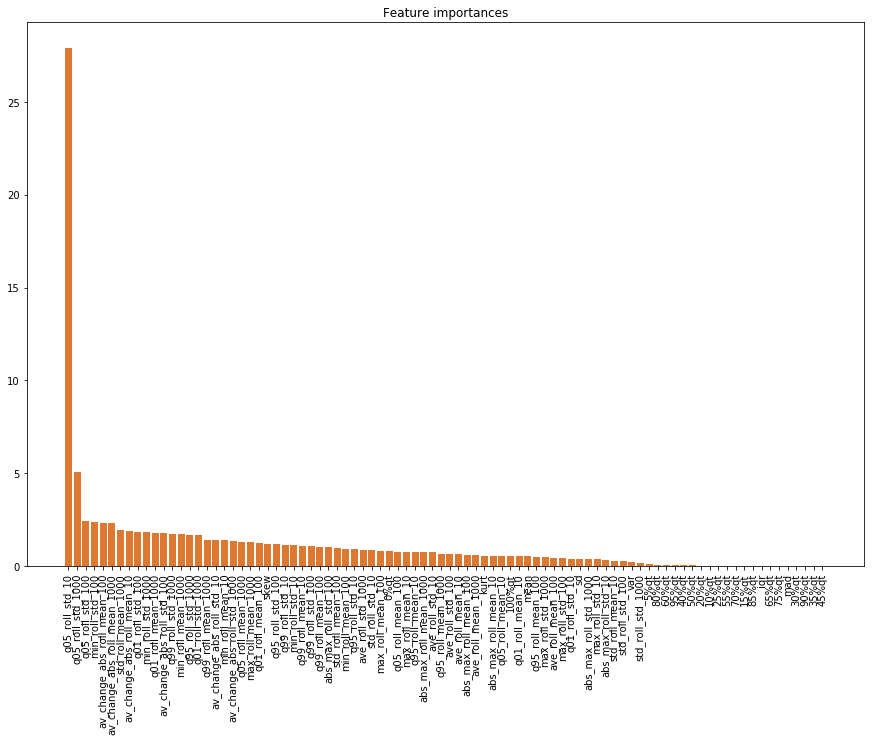

In [168]:
display_feature_importances(model_dtr.feature_importances_)

### RandomForestRegressor

In [19]:
from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(random_state=42, n_estimators=1000, n_jobs=-1)

In [20]:
model_rfr.fit(X_train, np.array(y_train).reshape(-1))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [9]:
display_cross_val_score(model_rfr, X_test, y_test)

Scores: [2.29149733 2.25687452 1.89478691 2.31814157 1.90579836 1.8579422
 1.95383246 2.19881323 2.04565085 1.95012882]
Mean: 2.067346624677138
Standard deviation: 0.17122121201754978


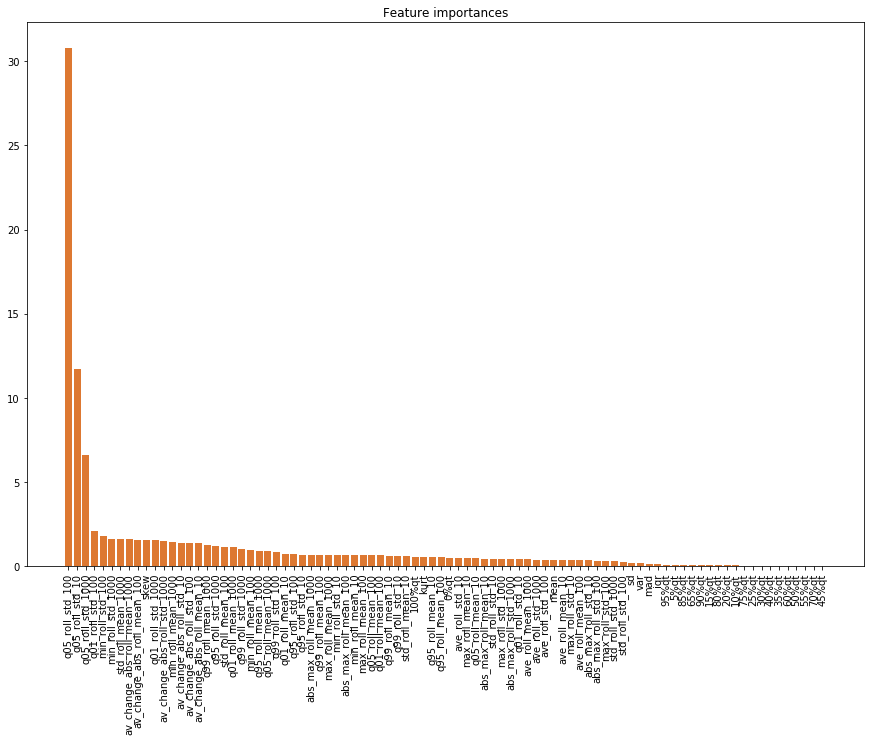

In [11]:
display_feature_importances(model_rfr.feature_importances_)

In [7]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, model_rfr.predict(X_test))

2.0671770250488786

In [207]:
from sklearn.externals import joblib
# save model
joblib.dump(model_rfr, "models/model_rfr.pkl")

['models/model_rfr.pkl']

In [6]:
from sklearn.externals import joblib
# load model
model_rfr = joblib.load("models/model_rfr.pkl")

/home/polmonroig/miniconda3/envs/env3.7/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/polmonroig/miniconda3/envs/env3.7/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### AdaBoost Decision Tree

Let's try the adaboost ensemble estimator with a DecisionTreeRegressor, to reduce overfitting we can reduce the number of estimators or relugarize the base estimator

In [293]:
from sklearn.ensemble import AdaBoostRegressor

model_ada_clf = AdaBoostRegressor(
                DecisionTreeRegressor(random_state=42,
                                      criterion="mae", max_depth=8),
                n_estimators=15, learning_rate=0.5)

In [294]:
model_ada_clf.fit(X_train, np.array(y_train).reshape(-1))

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
         learning_rate=0.5, loss='linear', n_estimators=15,
         random_state=None)

In [297]:
model_ada_clf.estimator_errors_

array([0.12855406, 0.13017132, 0.15517381, 0.18558161, 0.16704337,
       0.19982078, 0.17937816, 0.19172153, 0.15967036, 0.18591767,
       0.14939933, 0.1947424 , 0.18944194, 0.16173497, 0.16209201])

In [295]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_train, model_ada_clf.predict(X_train))

1.5076576723570787

In [296]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, model_ada_clf.predict(X_test))

2.070536982864124

In [291]:
display_cross_val_score(model_ada_clf, X_test, y_test)

Scores: [2.35784325 2.25050245 2.0162495  2.3007153  1.94583338 1.85792618
 2.15352276 2.36163363 2.09650858 2.04338032]
Mean: 2.1384115358224896
Standard deviation: 0.16690786254533277


In [206]:
from sklearn.externals import joblib
# save model
# joblib.dump(model_ada_clf, "models/model_ada_clf.pkl")

['models/model_ada_clf.pkl']

### Keras DNN using Tensorflow 2.0

In [265]:
# load libraries
import tensorflow as tf


# create model
network = tf.keras.models.Sequential()

l2_regularizer = 0.01

# define layers
network.add(tf.keras.layers.Dense(units=2000, 
                                  input_shape=(n_features, ), 
                                  activation=tf.keras.activations.elu,
                                  kernel_initializer=tf.keras.initializers.he_normal(seed=42),
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))

network.add(tf.keras.layers.Dense(units=2000, 
                                  activation=tf.keras.activations.elu,
                                  kernel_initializer=tf.keras.initializers.he_normal(seed=42),
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))

network.add(tf.keras.layers.Dense(units=2000, 
                                  activation=tf.keras.activations.elu,
                                  kernel_initializer=tf.keras.initializers.he_normal(seed=42),
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))

network.add(tf.keras.layers.Dense(units=2000, 
                                  activation=tf.keras.activations.elu,
                                  kernel_initializer=tf.keras.initializers.he_normal(seed=42),
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)))

network.add(tf.keras.layers.Dense(units=1))

# define optimizer
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

network.compile(optimizer=optimizer,
                loss="mae",
                metrics=['mae'])


In [266]:

#fit model
history = network.fit(X_train, y_train,
            verbose=1,
            epochs=100,
            batch_size=500,
            validation_data=(X_test, y_test))

Train on 3355 samples, validate on 839 samples
Epoch 1/100
3355/3355 [==============================] - 1s 341us/sample - loss: 216.8016 - mae: 19.8052 - val_loss: 195.8904 - val_mae: 3.6147
Epoch 2/100
3355/3355 [==============================] - 0s 67us/sample - loss: 192.5476 - mae: 4.0443 - val_loss: 185.9925 - val_mae: 3.2518
Epoch 3/100
3355/3355 [==============================] - 0s 67us/sample - loss: 180.9938 - mae: 2.6191 - val_loss: 174.1970 - val_mae: 2.2986
Epoch 4/100
3355/3355 [==============================] - 0s 68us/sample - loss: 169.4089 - mae: 2.1984 - val_loss: 162.7071 - val_mae: 2.3117
Epoch 5/100
3355/3355 [==============================] - 0s 67us/sample - loss: 157.7193 - mae: 2.0935 - val_loss: 150.8411 - val_mae: 2.0647
Epoch 6/100
3355/3355 [==============================] - 0s 67us/sample - loss: 146.0965 - mae: 2.0251 - val_loss: 139.5293 - val_mae: 2.1542
Epoch 7/100
3355/3355 [==============================] - 0s 67us/sample - loss: 134.8734 - mae: 2.0

Epoch 59/100
3355/3355 [==============================] - 0s 68us/sample - loss: 3.7637 - mae: 2.0158 - val_loss: 3.6834 - val_mae: 2.0098
Epoch 60/100
3355/3355 [==============================] - 0s 66us/sample - loss: 3.6549 - mae: 2.0342 - val_loss: 3.5686 - val_mae: 2.0185
Epoch 61/100
3355/3355 [==============================] - 0s 67us/sample - loss: 3.5195 - mae: 2.0167 - val_loss: 3.4523 - val_mae: 2.0148
Epoch 62/100
3355/3355 [==============================] - 0s 67us/sample - loss: 3.4102 - mae: 2.0161 - val_loss: 3.3520 - val_mae: 2.0174
Epoch 63/100
3355/3355 [==============================] - 0s 67us/sample - loss: 3.3317 - mae: 2.0368 - val_loss: 3.2765 - val_mae: 2.0383
Epoch 64/100
3355/3355 [==============================] - 0s 68us/sample - loss: 3.2265 - mae: 2.0240 - val_loss: 3.2001 - val_mae: 2.0496
Epoch 65/100
3355/3355 [==============================] - 0s 66us/sample - loss: 3.1469 - mae: 2.0306 - val_loss: 3.0997 - val_mae: 2.0313
Epoch 66/100
3355/3355 [===

In [216]:
# save model network.save("models/model.h5")

Now that we have our model trained let's visualize the loss and the mae

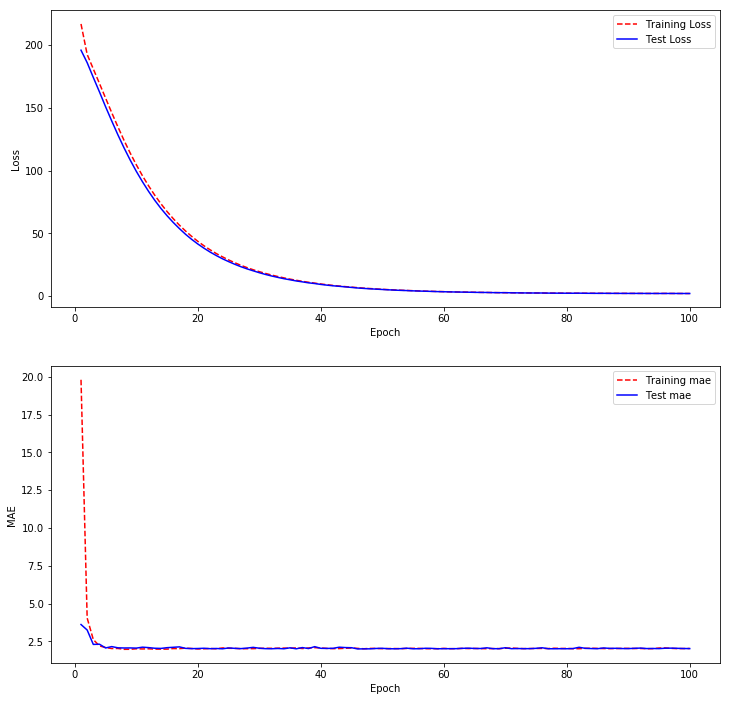

In [267]:
import matplotlib.pyplot as plt


training_loss = history.history['loss']
test_loss = history.history['val_loss']
training_mae= history.history['mae']
test_mae= history.history['val_mae']

epoch_count = range(1, len(training_loss) + 1)

plt.figure(1, figsize=(12, 12))
plt.subplot(211)
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(212)
plt.plot(epoch_count, training_mae, "r--")
plt.plot(epoch_count, test_mae, "b-")
plt.legend(["Training mae", "Test mae"])
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.show()

In [268]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, network.predict(X_test))

2.022367120991853

In [269]:
mean_absolute_error(y_train, network.predict(X_train))

2.020345071085677

## Submission

To make the submission first we need to create a dataset containing the testing information

In [53]:



def make_submission_dataset():
    sub_data = pd.DataFrame(index=range(n_test_files), dtype=np.float32,
                       columns=feature_columns)
    for i, file in enumerate(test_files):
        print_progress(i, n_test_files)
        seg = pd.read_csv(os.path.join(TEST_DATA_DIR, file))
        
        # for each instance we set the target to the mean
        sub_data.iloc[i][feature_columns[1]] = seg['acoustic_data'].mean()
        sub_data.iloc[i][feature_columns[2]] = seg['acoustic_data'].std()
        sub_data.iloc[i][feature_columns[3]] = seg['acoustic_data'].var()
        sub_data.iloc[i][feature_columns[4]] = robust.mad(np.array(seg['acoustic_data']))
        sub_data.iloc[i][feature_columns[5]] = stats.skew(np.array(seg['acoustic_data']))
        sub_data.iloc[i][feature_columns[6]] = stats.kurtosis(np.array(seg['acoustic_data']))
        
        for windows in [10, 100, 1000]:
            x_roll_std =  pd.Series(seg['acoustic_data'].values).rolling(windows).std().dropna().values
            x_roll_mean =  pd.Series(seg['acoustic_data'].values).rolling(windows).mean().dropna().values

            sub_data.loc[i]['ave_roll_std_' + str(windows)] = x_roll_std.mean()
            sub_data.loc[i]['std_roll_std_' + str(windows)] = x_roll_std.std()
            sub_data.loc[i]['max_roll_std_' + str(windows)] = x_roll_std.max()
            sub_data.loc[i]['min_roll_std_' + str(windows)] = x_roll_std.min()
            sub_data.loc[i]['q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
            sub_data.loc[i]['q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
            sub_data.loc[i]['q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
            sub_data.loc[i]['q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
            sub_data.loc[i]['av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
            sub_data.loc[i]['abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

            sub_data.loc[i]['ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
            sub_data.loc[i]['std_roll_mean_' + str(windows)] = x_roll_mean.std()
            sub_data.loc[i]['max_roll_mean_' + str(windows)] = x_roll_mean.max()
            sub_data.loc[i]['min_roll_mean_' + str(windows)] = x_roll_mean.min()
            sub_data.loc[i]['q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
            sub_data.loc[i]['q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
            sub_data.loc[i]['q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
            sub_data.loc[i]['q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
            sub_data.loc[i]['av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
            sub_data.loc[i]['abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()


        for j in range(0, 105, 5):
            sub_data.iloc[i][str(j) + "%qt"] = np.percentile(seg['acoustic_data'], j)
        sub_data.iloc[i][feature_columns[0]] = sub_data.iloc[i]["75%qt"] - sub_data.iloc[i]["25%qt"]  
    
    return sub_data

In [173]:
# make data
sub_data = make_submission_dataset()

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.

In [174]:
# save data to disk
# sub_data.to_csv(path_or_buf=os.path.join(DATA_DIR, "test_data.csv"), header=True, sep=",", index=False)

In [224]:
sub_data.head()

,iqr,mean,sd,var,mad,skew,kurt,0%qt,5%qt,10%qt,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
0,4.0,4.132894,6.256482,39.143560,2.965205,0.137942,46.601963,-121.0,-3.0,-1.0,...,4.132956,0.248140,4.826,3.212,3.537,3.704,4.533,4.630,7.651007e-07,4.826
1,4.0,3.774960,3.934244,15.478273,2.965205,0.056356,35.960785,-66.0,-1.0,0.0,...,3.775624,0.200369,4.315,3.254,3.366,3.457,4.138,4.225,-4.026845e-06,4.315
2,5.0,4.193207,7.136426,50.928577,2.965205,0.023299,59.146630,-156.0,-3.0,-1.0,...,4.191933,0.204330,5.331,3.420,3.725,3.866,4.523,4.731,2.798658e-06,5.331
3,5.0,4.437273,7.892545,62.292267,4.447807,0.271606,59.519596,-178.0,-4.0,-1.0,...,4.438105,0.215786,5.959,3.412,3.999,4.104,4.821,4.982,-1.610738e-07,5.959
4,4.0,4.064093,4.291452,18.416561,2.965205,0.361958,54.503807,-79.0,-1.0,0.0,...,4.064523,0.226683,5.019,3.460,3.629,3.731,4.448,4.585,-1.234899e-06,5.019


In [ ]:
def blend_pred(estimators, data):
    blended_sub = pd.DataFrame(index=range(n_test_files),
                       columns=["seg_id", "time_to_failure"])
    for estimator in estimators:
        

In [298]:
# load data from disk
sub_data = pd.read_csv(os.path.join(DATA_DIR, "test_data.csv"))

In [299]:
# noramlize data
scaler = StandardScaler()
sub_data = scaler.fit_transform(sub_data)

In [300]:
x = model_ada_clf.predict(sub_data)

In [ ]:
x2 = network.

In [301]:
for i in x:
    print(i)

6.709652
9.081644
6.709652
3.3232815
10.531533
8.925778999999999
7.2175474
1.6066486
6.866872
7.068567999999999
9.081644
10.380560000000001
6.4012794
7.068567999999999
10.7755015
8.925778999999999
2.2220209
3.3219900000000004
9.789212
3.4852638
1.7282921000000002
8.364308
6.836223599999999
7.068567999999999
3.7496972
10.998444000000001
8.7149935
6.7250308
6.711007
3.273739
8.925778999999999
7.9395742
3.3928025
4.9513903
8.925778999999999
5.14371205
7.068567999999999
3.3219900000000004
2.6135147
6.260223000000001
3.4852638
6.709652
2.2996304
7.9395742
7.9395742
6.836223599999999
10.318672
7.614910399999999
1.8572168000000002
10.9038125
1.23738605
1.7282921000000002
3.4023845
1.8780401999999998
8.55913
3.3410102999999998
6.7250308
10.880227
6.55456735
2.9131374
3.2500374
4.687041000000001
3.5242345
2.2220209
2.2220209
7.068567999999999
8.760163
3.3219900000000004
6.282398000000001
3.5777965999999997
8.7149935
5.364033
8.1045875
6.7178830000000005
6.836223599999999
1.7282921000000002
2.07

In [304]:
x.mean()

5.570202111711128

In [250]:
submission = pd.DataFrame(index=range(n_test_files),
                       columns=["seg_id", "time_to_failure"])

In [ ]:
submission

In [251]:
file_ids = []
for file in test_files:
    file_ids.append(file[:-4])

In [252]:
submission['seg_id'] = file_ids
submission['time_to_failure'] = x

In [253]:
submission.to_csv("submission.csv", sep=',', encoding='utf-8', index=False)

In [254]:
pd.read_csv("submission.csv")

,seg_id,time_to_failure
0,seg_c654e7,6.005604
1,seg_739856,9.207150
2,seg_1b08a4,5.218758
3,seg_e30e44,2.186191
4,seg_b4402d,9.845011
5,seg_284923,10.100579
6,seg_b402ac,5.977416
7,seg_655780,2.468509
8,seg_8bf229,6.175128
9,seg_2a0dc0,8.531857
